# Task 5: Account Security Monitoring

Karena Thailand faces over 5,000 confirmed account thefts monthly (actual number likely 2x higher), making it the #1 customer support issue consuming 60% of team resources. Beyond theft, sophisticated account selling rings destroy competitive integrity, bot farms operate 24/7 causing game economy inflation, and players exploit VPNs for regional pricing (70% discounts), costing millions of baht annually. The current rule-based security system has 60% false positive rate--flagging legitimate travelers while missing smart attackers who wait 24 hours between actions. Simple thresholds flag players who legitimately improve while missing gradual botting patterns. The security team drowns in alerts while real threats slip through. The company needs an intelligent unsupervised anomaly detection system that learns normal behavior patterns and flags truly unusual activities without rigid rules or labeled data.

# STEP 1: Import and setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, classification_report
import warnings
warnings.filterwarnings('ignore')


# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All libraries imported successfully!")
print(f"✓ Random seed set to {RANDOM_STATE}")

✓ All libraries imported successfully!
✓ Random seed set to 42


In [ ]:
# Load training data
train_df = pd.read_csv('/content/drive/MyDrive/CPE_KMUTT/Year3/Semester_1-68/CPE342_MachineLearning/CPE342_Lab/Kaggle_PlayerIntelligenceSystem/Task5_AccountSecurityMonitoring/test.csv')
train_df.head()

,id,player_id,login_count_1,login_count_2,login_count_3,login_count_4,login_lat_1,login_lon_1,login_lat_2,login_lon_2,...,guild_changes_1,guild_changes_2,guild_changes_3,guild_changes_4,account_age_days,behavior_stability,password_changed,vpn_usage,suspicious_login_time,mass_item_sale
0,ANS00001,P011753,31.222232,41.790417,28.048736,NaN,-17.074035,127.285635,-17.554811,126.865553,...,1.0,2.0,2.0,1.0,580.020715,0.830282,0.0,1.0,0.0,0.0
1,ANS00002,P010021,61.358999,49.209284,NaN,NaN,48.430879,25.555743,48.708993,26.733951,...,0.0,-1.0,-1.0,1.0,1306.627890,0.700770,0.0,NaN,0.0,0.0
2,ANS00003,P006725,24.763478,37.723228,26.879628,32.503285,8.252684,40.788695,8.346856,40.688039,...,0.0,1.0,-1.0,0.0,835.638378,0.797991,0.0,0.0,0.0,0.0
3,ANS00004,P018170,82.100747,74.862388,73.520927,83.495309,-28.728293,178.990465,-29.104994,178.810800,...,2.0,2.0,1.0,3.0,NaN,0.736845,0.0,NaN,0.0,0.0
4,ANS00005,P003027,50.901216,70.636572,55.606357,68.179388,-46.833704,167.886402,-47.372141,166.767058,...,NaN,-1.0,0.0,0.0,379.053416,0.818901,NaN,0.0,0.0,0.0


In [ ]:
train_df.shape

(25889, 124)

# STEP 3: Exploratory Data Analysis

In [ ]:
# Missing values
missing_stats = pd.DataFrame({
    'Column': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Missing_Pct': 100 * train_df.isnull().sum() / len(train_df)
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(f"\nMissing Value Summary:")
print(f"  Total columns with missing: {len(missing_stats)}")
print(f"  Total missing values: {train_df.isnull().sum().sum()}")
print(f"  Missing percentage range: {missing_stats['Missing_Pct'].min():.2f}% - {missing_stats['Missing_Pct'].max():.2f}%")

# Display top 10
print("\nTop 10 columns with most missing values:")
print(missing_stats.head(10).to_string(index=False))


Missing Value Summary:
  Total columns with missing: 122
  Total missing values: 153936
  Missing percentage range: 4.50% - 5.26%

Top 10 columns with most missing values:
                    Column  Missing_Count  Missing_Pct
         ip_hash_entropy_1           1363     5.264784
                kda_mean_1           1334     5.152768
           accuracy_mean_2           1333     5.148905
                 kda_std_2           1332     5.145042
               login_lon_1           1322     5.106416
             login_count_4           1320     5.098691
          activity_level_2           1320     5.098691
play_pattern_consistency_3           1317     5.087103
          activity_level_1           1315     5.079377
         ip_hash_entropy_2           1310     5.060064


# STEP 4: Feature Engineering

In [ ]:
def create_features(df):
    df_feat = df.copy()

    print("Creating new features...")

    # Identify temporal features (those with _1, _2, _3, _4 suffixes)
    temporal_groups = {}
    for col in df_feat.columns:
        if col.endswith(('_1', '_2', '_3', '_4')):
            base = col[:-2]
            if base not in temporal_groups:
                temporal_groups[base] = []
            temporal_groups[base].append(col)

    print(f"  Found {len(temporal_groups)} temporal feature groups")

    # Create aggregated temporal features
    for base, cols in temporal_groups.items():
        available = [c for c in cols if c in df_feat.columns]
        if len(available) >= 2:
            # Mean, std, trend
            df_feat[f'{base}_mean'] = df_feat[available].mean(axis=1)
            df_feat[f'{base}_std'] = df_feat[available].std(axis=1)
            if len(available) >= 3:
                df_feat[f'{base}_trend'] = df_feat[available[-1]] - df_feat[available[0]]
                # Coefficient of variation
                mean_val = df_feat[available].mean(axis=1)
                std_val = df_feat[available].std(axis=1)
                df_feat[f'{base}_cv'] = std_val / (mean_val + 1e-6)

    # Location features
    lat_cols = [c for c in df_feat.columns if 'login_lat_' in c and c[-1].isdigit()]
    lon_cols = [c for c in df_feat.columns if 'login_lon_' in c and c[-1].isdigit()]

    if len(lat_cols) >= 2:
        distances = []
        for i in range(len(lat_cols)-1):
            if lat_cols[i] in df_feat.columns and lon_cols[i] in df_feat.columns:
                if lat_cols[i+1] in df_feat.columns and lon_cols[i+1] in df_feat.columns:
                    dist = np.sqrt(
                        (df_feat[lat_cols[i+1]] - df_feat[lat_cols[i]])**2 +
                        (df_feat[lon_cols[i+1]] - df_feat[lon_cols[i]])**2
                    )
                    df_feat[f'distance_period_{i+1}_to_{i+2}'] = dist
                    distances.append(f'distance_period_{i+1}_to_{i+2}')

        if distances:
            df_feat['total_distance'] = df_feat[distances].sum(axis=1)
            df_feat['max_distance'] = df_feat[distances].max(axis=1)

    # Behavioral features
    if 'skill_rating_mean' in df_feat.columns:
        df_feat['skill_volatility'] = df_feat['skill_rating_std']

    # Economic features
    purchase_cols = [c for c in df_feat.columns if 'purchase_frequency_' in c and c[-1].isdigit()]
    if purchase_cols:
        df_feat['total_purchases'] = df_feat[purchase_cols].sum(axis=1)

    refund_cols = [c for c in df_feat.columns if 'refund_count_' in c and c[-1].isdigit()]
    if refund_cols:
        df_feat['total_refunds'] = df_feat[refund_cols].sum(axis=1)
        if 'total_purchases' in df_feat.columns:
            df_feat['refund_rate'] = df_feat['total_refunds'] / (df_feat['total_purchases'] + 1)

    # Social features
    friend_add_cols = [c for c in df_feat.columns if 'friend_adds_' in c and c[-1].isdigit()]
    friend_rem_cols = [c for c in df_feat.columns if 'friend_removes_' in c and c[-1].isdigit()]

    if friend_add_cols and friend_rem_cols:
        df_feat['total_friend_adds'] = df_feat[friend_add_cols].sum(axis=1)
        df_feat['total_friend_removes'] = df_feat[friend_rem_cols].sum(axis=1)
        df_feat['friend_churn'] = df_feat['total_friend_removes'] / (df_feat['total_friend_adds'] + 1)

    # Security flags
    security_cols = ['password_changed', 'vpn_usage', 'suspicious_login_time', 'mass_item_sale']
    available_security = [c for c in security_cols if c in df_feat.columns]
    if available_security:
        df_feat['security_flag_count'] = df_feat[available_security].sum(axis=1)

    # Activity ratios
    if 'activity_level_mean' in df_feat.columns and 'account_age_days' in df_feat.columns:
        df_feat['activity_per_day'] = df_feat['activity_level_mean'] / (df_feat['account_age_days'] + 1)

    new_features = len([c for c in df_feat.columns if c not in df.columns])
    print(f"  ✓ Created {new_features} new features")
    print(f"  ✓ Total features: {df_feat.shape[1]}")

    return df_feat

In [ ]:
# Apply feature engineering
train_df_eng = create_features(train_df)
train_df_eng.head()

Creating new features...
  Found 29 temporal feature groups
  ✓ Created 130 new features
  ✓ Total features: 254


,id,player_id,login_count_1,login_count_2,login_count_3,login_count_4,login_lat_1,login_lon_1,login_lat_2,login_lon_2,...,max_distance,skill_volatility,total_purchases,total_refunds,refund_rate,total_friend_adds,total_friend_removes,friend_churn,security_flag_count,activity_per_day
0,ANS00001,P011753,31.222232,41.790417,28.048736,NaN,-17.074035,127.285635,-17.554811,126.865553,...,1.815586,10.734244,15.651627,-1.0,-0.060054,58.689234,11.746821,0.196800,1.0,0.001410
1,ANS00002,P010021,61.358999,49.209284,NaN,NaN,48.430879,25.555743,48.708993,26.733951,...,1.210588,15.051734,8.522978,6.0,0.630055,9.005491,12.580792,1.257389,0.0,0.001019
2,ANS00003,P006725,24.763478,37.723228,26.879628,32.503285,8.252684,40.788695,8.346856,40.688039,...,1.683149,34.229071,16.133845,0.0,0.000000,8.258483,7.417035,0.801107,0.0,0.000802
3,ANS00004,P018170,82.100747,74.862388,73.520927,83.495309,-28.728293,178.990465,-29.104994,178.810800,...,1.799015,82.824652,20.241188,4.0,0.188313,18.536921,11.861979,0.607157,0.0,NaN
4,ANS00005,P003027,50.901216,70.636572,55.606357,68.179388,-46.833704,167.886402,-47.372141,166.767058,...,1.242113,36.587693,1.656779,2.0,0.752791,27.674836,13.281753,0.463185,0.0,0.002712


# STEP 5: Data Preprocessing

In [ ]:
# Separate features
ID_COLS = ['id', 'player_id']
TARGET_COL = 'is_anomaly' # we don't have this target in dataset

# Extract IDs
train_ids = train_df_eng[ID_COLS].copy()

# Extract target
y_train = train_df_eng[TARGET_COL].copy() if TARGET_COL in train_df_eng.columns else None

In [ ]:
# Extract features
feature_cols = [c for c in train_df_eng.columns if c not in ID_COLS + [TARGET_COL]]
X_train = train_df_eng[feature_cols].copy()
X_test = None

print(f"Feature columns: {len(feature_cols)}")
print(f"Training samples: {len(X_train)}")

Feature columns: 252
Training samples: 25889


In [ ]:
# Handle infinite values
X_train = X_train.replace([np.inf, -np.inf], np.nan)

In [ ]:
# KNN Imputation
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imp = None
print(f"  ✓ Missing values after imputation: {X_train_imp.isnull().sum().sum()}")

  ✓ Missing values after imputation: 0


In [ ]:
# Outlier capping
for col in X_train_imp.columns:
    q01 = X_train_imp[col].quantile(0.01)
    q99 = X_train_imp[col].quantile(0.99)
    X_train_imp[col] = X_train_imp[col].clip(q01, q99)

In [ ]:
# Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imp),
    columns=X_train_imp.columns,
    index=X_train_imp.index
)
X_test_scaled = None

# STEP 6: Training anomaly detection ensemble

In [ ]:
# Set contamination based on observed anomaly rate or estimate
if y_train is not None:
    contamination = y_train.mean()
    print(f"Using observed contamination: {contamination:.4f}")
else:
    contamination = 0.05  # Default: 5%
    print(f"Using estimated contamination: {contamination:.4f}")

Using estimated contamination: 0.0500


In [ ]:
# Initialize models
models = {}
model_scores = {}

In [ ]:
# Model 1: Isolation Forest
print("\n1. Training Isolation Forest...")
iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators=200,
    max_samples=256,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso_forest.fit(X_train_scaled)
iso_scores = -iso_forest.decision_function(X_train_scaled)
models['isolation_forest'] = iso_forest
model_scores['isolation_forest'] = iso_scores
print("  ✓ Isolation Forest trained")


1. Training Isolation Forest...
  ✓ Isolation Forest trained


In [ ]:
# Model 2: Local Outlier Factor
print("2. Training Local Outlier Factor...")
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination,
    novelty=True,
    n_jobs=-1
)
lof.fit(X_train_scaled)
lof_scores = -lof.decision_function(X_train_scaled)
models['lof'] = lof
model_scores['lof'] = lof_scores
print("  ✓ LOF trained")

2. Training Local Outlier Factor...
  ✓ LOF trained


In [ ]:
# Model 3: Elliptic Envelope (may fail if covariance is singular)
print("3. Training Elliptic Envelope...")
try:
    elliptic = EllipticEnvelope(
        contamination=contamination,
        random_state=RANDOM_STATE
    )
    elliptic.fit(X_train_scaled)
    elliptic_scores = -elliptic.decision_function(X_train_scaled)
    models['elliptic'] = elliptic
    model_scores['elliptic'] = elliptic_scores
    print("  ✓ Elliptic Envelope trained")
except:
    print("  ✗ Elliptic Envelope failed (singular covariance)")

In [ ]:
# Model 4: PCA-based Anomaly Detection
print("4. Training PCA Anomaly Detector...")
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train_scaled)
X_reconstructed = pca.inverse_transform(X_pca)
pca_scores = np.mean((X_train_scaled - X_reconstructed) ** 2, axis=1)
models['pca'] = pca
model_scores['pca'] = pca_scores
print(f"  ✓ PCA trained ({pca.n_components_} components)")

In [ ]:
# Model 5: Statistical (Z-score based)
print("5. Creating Statistical Anomaly Detector...")
mean_vals = X_train_scaled.mean()
std_vals = X_train_scaled.std()
z_scores = np.abs((X_train_scaled - mean_vals) / (std_vals + 1e-6))
stat_scores = z_scores.max(axis=1)
model_scores['statistical'] = stat_scores.values
print("  ✓ Statistical detector ready")

# STEP 7: Calculate Model Weights

In [ ]:
def f3_score(y_true, y_pred):
    """Calculate F3 score"""
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    if precision + recall == 0:
        return 0
    return 10 * precision * recall / (9 * precision + recall)

In [ ]:
weights = {}

if y_train is not None:
    print("Calculating weights based on F3 performance...\n")

    for name, scores in model_scores.items():
        # Determine threshold
        threshold = np.percentile(scores, 100 * (1 - contamination))
        predictions = (scores > threshold).astype(int)

        # Calculate F3
        f3 = f3_score(y_train, predictions)
        weights[name] = f3

        print(f"  {name:20s}: F3 = {f3:.4f}")

    # Normalize weights
    total_weight = sum(weights.values())
    if total_weight > 0:
        weights = {k: v/total_weight for k, v in weights.items()}
    else:
        n = len(weights)
        weights = {k: 1.0/n for k in weights.keys()}

    print("\nNormalized Weights:")
    for name, weight in weights.items():
        print(f"  {name:20s}: {weight:.4f}")
else:
    # Equal weights
    n = len(model_scores)
    weights = {name: 1.0/n for name in model_scores.keys()}
    print("No labels available - using equal weights")

# STEP 8: Ensemble Predictions

In [ ]:
def ensemble_predict(model_scores_dict, weights_dict, threshold_percentile=None):

    # Normalize each score to [0, 1]
    normalized_scores = []
    score_weights = []

    for name, scores in model_scores_dict.items():
        # Normalize
        smin, smax = scores.min(), scores.max()
        if smax > smin:
            norm_scores = (scores - smin) / (smax - smin)
        else:
            norm_scores = np.zeros_like(scores)

        normalized_scores.append(norm_scores)
        score_weights.append(weights_dict.get(name, 1.0))

    # Weighted average
    score_weights = np.array(score_weights)
    score_weights = score_weights / score_weights.sum()

    ensemble_scores = np.zeros(len(normalized_scores[0]))
    for scores, weight in zip(normalized_scores, score_weights):
        ensemble_scores += weight * scores

    # Determine threshold
    if threshold_percentile is None:
        threshold_percentile = 100 * (1 - contamination)

    threshold = np.percentile(ensemble_scores, threshold_percentile)
    predictions = (ensemble_scores > threshold).astype(int)

    return predictions, ensemble_scores, threshold

In [ ]:
# Get training predictions
train_preds, train_ensemble_scores, train_threshold = ensemble_predict(
    model_scores, weights
)

print(f"Ensemble threshold: {train_threshold:.6f}")
print(f"Predicted anomalies: {train_preds.sum()} ({100*train_preds.mean():.2f}%)")

Ensemble threshold: 0.222184
Predicted anomalies: 1295 (5.00%)


# STEP 9: Evaluate on Training Data

In [ ]:
if y_train is not None:
    print("\n" + "="*70)
    print("STEP 9: EVALUATION ON TRAINING DATA")
    print("="*70)

    from sklearn.metrics import confusion_matrix, classification_report

    # Basic metrics
    precision = precision_score(y_train, train_preds)
    recall = recall_score(y_train, train_preds)
    f3 = f3_score(y_train, train_preds)

    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F3 Score:  {f3:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_train, train_preds)
    print("\nConfusion Matrix:")
    print(f"{'':12s} Predicted")
    print(f"{'':12s}    0       1")
    print(f"Actual 0  {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"Actual 1  {cm[1,0]:6d}  {cm[1,1]:6d}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_train, train_preds, digits=4))

    # Optimize threshold
    print("\n" + "="*70)
    print("OPTIMIZING THRESHOLD FOR F3 SCORE")
    print("="*70)

    best_f3 = 0
    best_threshold_pct = None

    for pct in np.arange(90, 99.5, 0.5):
        preds_temp, _, _ = ensemble_predict(model_scores, weights, threshold_percentile=pct)
        f3_temp = f3_score(y_train, preds_temp)

        if f3_temp > best_f3:
            best_f3 = f3_temp
            best_threshold_pct = pct

    print(f"\nOptimal threshold percentile: {best_threshold_pct:.1f}")
    print(f"Optimal F3 score: {best_f3:.4f}")

    # Re-predict with optimal threshold
    train_preds_opt, train_scores_opt, threshold_opt = ensemble_predict(
        model_scores, weights, threshold_percentile=best_threshold_pct
    )

    precision_opt = precision_score(y_train, train_preds_opt)
    recall_opt = recall_score(y_train, train_preds_opt)

    print(f"\nOptimized Performance:")
    print(f"  Precision: {precision_opt:.4f}")
    print(f"  Recall:    {recall_opt:.4f}")
    print(f"  F3 Score:  {best_f3:.4f}")

    # Use optimized threshold
    train_threshold = threshold_opt
    train_preds = train_preds_opt
    train_ensemble_scores = train_scores_opt

# STEP 10: Visualizations

✓ Visualization saved: anomaly_detection_results.png


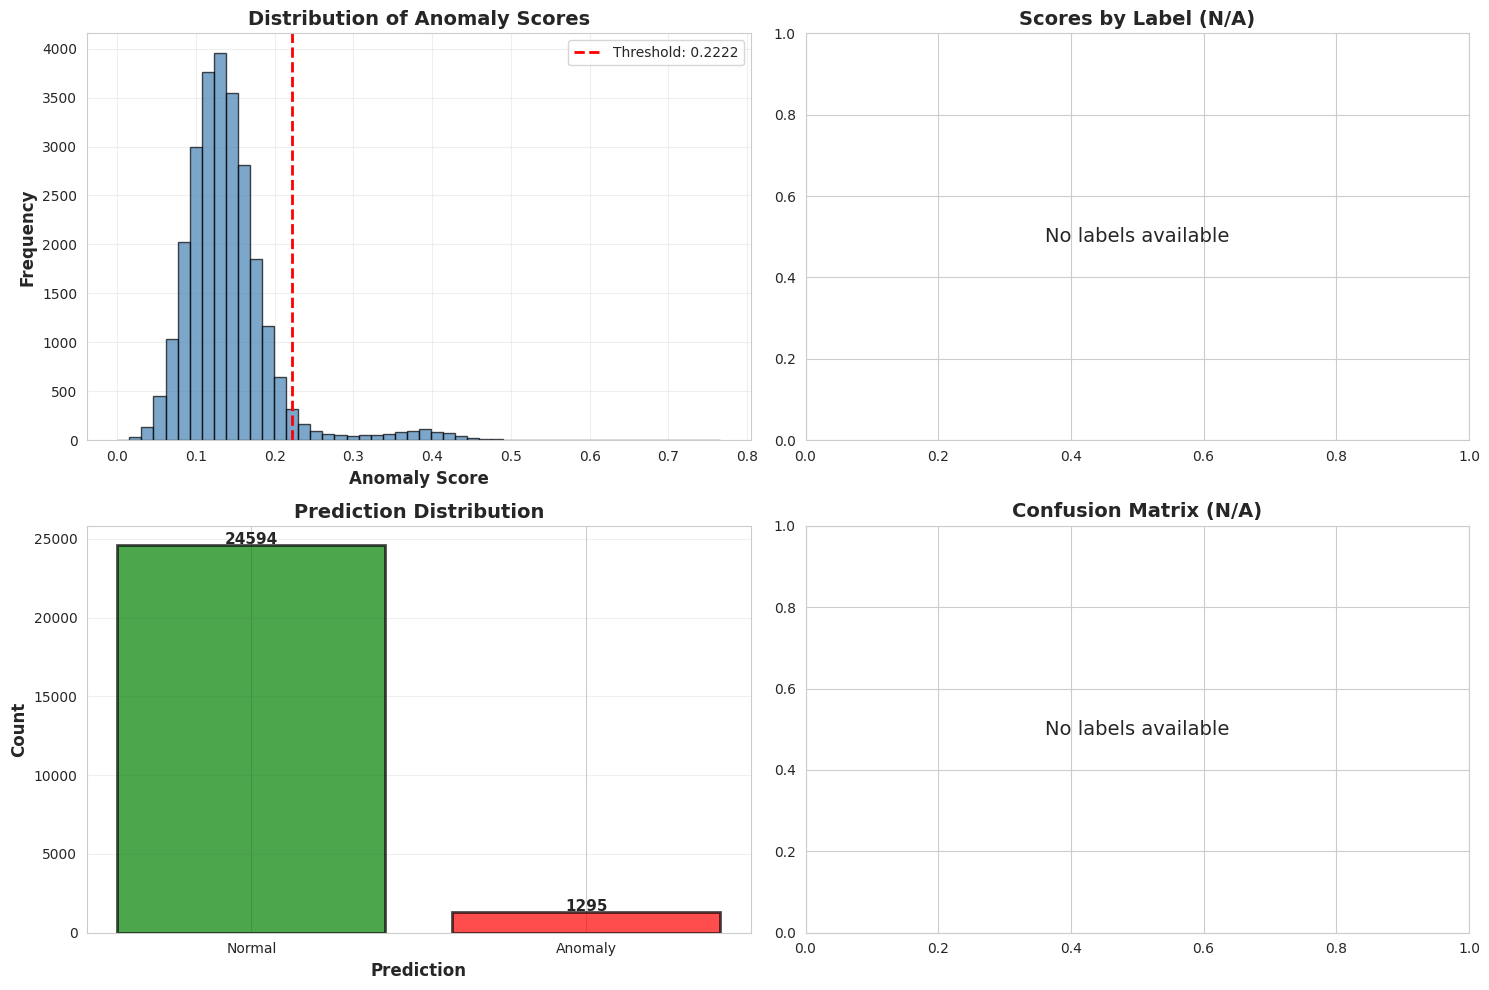

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Score Distribution
ax = axes[0, 0]
ax.hist(train_ensemble_scores, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(train_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {train_threshold:.4f}')
ax.set_xlabel('Anomaly Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Anomaly Scores', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Scores by True Label
ax = axes[0, 1]
if y_train is not None:
    normal_scores = train_ensemble_scores[y_train == 0]
    anomaly_scores = train_ensemble_scores[y_train == 1]

    bp = ax.boxplot([normal_scores, anomaly_scores],
                     labels=['Normal', 'Anomaly'],
                     patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    ax.set_ylabel('Anomaly Score', fontsize=12, fontweight='bold')
    ax.set_title('Scores by True Label', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No labels available', ha='center', va='center', fontsize=14)
    ax.set_title('Scores by Label (N/A)', fontsize=14, fontweight='bold')

# Plot 3: Prediction Distribution
ax = axes[1, 0]
pred_counts = pd.Series(train_preds).value_counts().sort_index()
colors = ['green', 'red']
bars = ax.bar(pred_counts.index, pred_counts.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xlabel('Prediction', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Normal', 'Anomaly'])
for i, (bar, count) in enumerate(zip(bars, pred_counts.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            str(count), ha='center', fontsize=11, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Plot 4: Confusion Matrix
ax = axes[1, 1]
if y_train is not None:
    cm = confusion_matrix(y_train, train_preds)
    im = ax.imshow(cm, cmap='RdYlGn_r', alpha=0.7)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Normal', 'Anomaly'], fontsize=11)
    ax.set_yticklabels(['Normal', 'Anomaly'], fontsize=11)
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, str(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=18, fontweight='bold')
    plt.colorbar(im, ax=ax)
else:
    ax.text(0.5, 0.5, 'No labels available', ha='center', va='center', fontsize=14)
    ax.set_title('Confusion Matrix (N/A)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('anomaly_detection_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: anomaly_detection_results.png")
plt.show()

# Summary

In [ ]:
print("\nModel Performance:")
if y_train is not None:
    print(f"  Training F3 Score: {best_f3:.4f}")
    print(f"  Training Precision: {precision_opt:.4f}")
    print(f"  Training Recall: {recall_opt:.4f}")
else:
    print("  No labels available for evaluation")

print(f"\nDataset Statistics:")
print(f"  Total training samples: {len(train_df)}")
if X_test_scaled is not None:
    print(f"  Total test samples: {len(test_df)}")
print(f"  Total features engineered: {len(feature_cols)}")
print(f"  Contamination rate: {contamination:.4f}")

print(f"\nPredictions:")
print(f"  Training anomalies detected: {train_preds.sum()} ({100*train_preds.mean():.2f}%)")
if X_test_scaled is not None:
    print(f"  Test anomalies detected: {test_preds.sum()} ({100*test_preds.mean():.2f}%)")

print(f"\nModels Used:")
for i, (name, weight) in enumerate(weights.items(), 1):
    print(f"  {i}. {name.replace('_', ' ').title():25s} (weight: {weight:.4f})")

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)
print("\nOutput Files:")
if X_test_scaled is not None:
    print("  ✓ submission.csv - Ready for submission")
print("  ✓ anomaly_detection_results.png - Visualizations")


Model Performance:
  No labels available for evaluation

Dataset Statistics:
  Total training samples: 25889
  Total features engineered: 252
  Contamination rate: 0.0500

Predictions:
  Training anomalies detected: 1295 (5.00%)

Models Used:
  1. Isolation Forest          (weight: 0.2000)
  2. Lof                       (weight: 0.2000)
  3. Elliptic                  (weight: 0.2000)
  4. Pca                       (weight: 0.2000)
  5. Statistical               (weight: 0.2000)

PIPELINE COMPLETE!

Output Files:
  ✓ anomaly_detection_results.png - Visualizations


In [ ]:
sample_submission_path = '/content/drive/MyDrive/CPE_KMUTT/Year3/Semester_1-68/CPE342_MachineLearning/CPE342_Lab/Kaggle_PlayerIntelligenceSystem/sample_submission.csv'
sample_submission_df = pd.read_csv(sample_submission_path)

# Create a DataFrame for the anomaly predictions
prediction_results = pd.DataFrame({'id': train_ids['id'], 'task5': train_preds})

# Merge with the sample submission to maintain the correct format
submission_df = sample_submission_df.merge(prediction_results, on='id', how='left', suffixes=('_sample', None))

# Drop the original task5_sample column if it exists and rename the new task5 column
if 'task5_sample' in submission_df.columns:
    submission_df = submission_df.drop(columns=['task5_sample'])

# Ensure task5 column is integer type as per typical submission requirements
submission_df['task5'] = submission_df['task5'].astype(int)

# Fill any NaN values with 0
submission_df = submission_df.fillna(0)

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("✓ Submission file 'submission.csv' created successfully!")

✓ Submission file 'submission.csv' created successfully!


In [ ]:
submission_df.head()

,id,task1,task2,task3,task4,task5
0,ANS00001,1.0,2.0,2983.20,0.0,0
1,ANS00002,0.0,1.0,529.00,1.0,0
2,ANS00003,1.0,3.0,15682.45,2.0,0
3,ANS00004,0.0,2.0,7200.00,0.0,0
4,ANS00005,0.0,0.0,0.00,0.0,0
